# Implementacion LoRa con SDRs

El siguiente trabajo corresponde con el trabajo final de la materia Comunicaciones Digitales y va acompañado de otro documento (ver [LoRa Colab](https://colab.research.google.com/drive/1h2IXyGuUeMVAclkKdN0WSgI6xDmE24Y8#scrollTo=yPvJQi2uodbl)) que fundamenta y explaya lo aqui demostrado.

Autores:

*   Marcos Raimondi
*   Gaston Marcelo Segura
*   Giuliano Matias Palombarini

Fecha:

*   08/2023

## Introduccion

El trabajo consiste en realizar una transmisión LoRa con Radios Definidas por Software (SDRs). Para ello se implementan los conocimientos vistos en el trabajo adjunto, reemplazando el canal simulado por uno real. La transmision y recepcion se realiza utilizando un dispositivo con la funcion de loopback (digital o analogico). 
Es de interés destacar que para hacer posible la correcta recepcion de la señal se define una trama cuya primera parte es un preambulo de N upchirps, seguido de M simbolos. En el receptor primero se intenta detectar el preambulo y posteriormente los simbolos de la comunicacion.

Para ahondar más en la teoría de la comunicacion LoRa, revisar el documento adjunto [LoRa Colab](https://colab.research.google.com/drive/1h2IXyGuUeMVAclkKdN0WSgI6xDmE24Y8#scrollTo=yPvJQi2uodbl).

In [38]:
# Run these lines of code if this is your first time using this Jupyter Notebook

#! pip install pyadi-iio
#! pip install scikit-dsp-comm
#! pip install scikit-commpy

In [39]:
#-----------------------------------------lIBRERIAS--------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

import adi
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.signal import spectrogram

## Funciones de Graficos

In [40]:
def plot_spectrogram(title, rxSignal_reconstruida, samples):
    # genera un espectrograma
    plt.figure()
    ff, tt, Sxx = spectrogram(rxSignal_reconstruida , fs =samples, nperseg=100, noverlap=50, mode='psd')
    plt.pcolormesh(tt, ff, Sxx)              
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('Frequency')
    plt.axis(ymax = 1)
    plt.grid()
    plt.show()

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):
    # genera el grafico de la forma de onda        
    ax.set_facecolor('white')
    ax.set_title(title, fontdict={'color':'black','weight':'bold','size' : 20}, pad = 20)
    ax.set_xlabel(axis_x_label, fontdict={'color':'black','weight':'bold','size' : 20}, labelpad = 10)
    ax.set_ylabel(axis_y_label, fontdict={'color':'black','weight':'bold','size' : 20}, labelpad = 5)
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    ax.set_xticks(np.arange(0, len_packet_tx, Ts))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
    ax.plot(t, wf,color = "red", lw=2)   
    ax.grid()
    plt.show()
    
def graficar_correlaciones(corrs,simbolos_estimados,sf):
    # Genera el grafico de las correlaciones
    legends = []
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,2)
    plt.xlim(2**sf)
    plt.title('Componente de frecuencia de la señal')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud')
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                         right=0.9, 
                           top=0.9, 
                        wspace=0.2, 
                       hspace=0.35)
    
    for i in range(len(simbolos_estimados)):
        plt.plot(corrs[i]/max(abs(corrs[i])))
        legends.append(f"simbolo {simbolos_estimados[i]}")
        
    plt.legend(legends)
    plt.show()

## Transmisor

### Funciones de Transmision

In [41]:
def generate_chirp(simbolo, sf, Bw, time_interval, Nsamples):
  """
  generate_chirp, genera la frecuencia de un chirp que va de 0 a 2**sf y esta shifteado por
    Arguments:
        simbolo       : simbolo a enviar
        sf            : spreading factor
        Bw            : Ancho de banda
        time_interval : vector de tiempo
        Nsamples      : samples per symbol
        
    Returns:
        wf_f          : frecuencia del chirps del simbolo
         
  """
  M = 2**sf
  Ts = M/np.abs(Bw)   # Tiempo por simbolo. Ts=2^{SF}/Bw   
  wf_f = (simbolo*np.abs(Bw)/M + Bw/Ts*time_interval) % np.abs(Bw)           

  return wf_f         # Vector que contiene la forma de onda final,cuya f varia linealmente con el t

def generate_preamble(Nchirps, Bw, sf, Nsamples):
  """
  generate_preamble, genera los simbolos de preambulo (upchirps)
    Arguments:
        Nchirps   : cantidad de simbolos de preambulo
        Bw        : ancho de banda en kHz
        Nsamples  : cantidad de muestras por simbolo
        sf        : spreading factor
    Returns:
        preamble  : frecuencia de chirps de preambulo
  """
  f_0 = 0         # frecuencia inicial del chirp
  Ts = 2**sf/Bw   # tiempo de simbolo
  preamble = np.array([])
  t_chirp = np.linspace(0, Ts, Nsamples)

  for i in range(Nchirps):
    preamble = np.append(preamble, generate_chirp(f_0, sf, Bw,  t_chirp,sps))

  return preamble

def generate_symbols(sf,Nsymbols, Bw, samples):
  """
  generate_symbols, genera los simbolos aleatorios a transmitir y sus frecuencias
    Arguments:
        sf        : spreading factor
        Nsymbols  : cantidad de simbolos a transmitir
        Bw        : Ancho de banda
        samples   : samples per symbol
        
    Returns:
        symbols   : arreglo de simbolos a transmitir generados aleatoriamente
        chirps    : frecuencia de los chirps de cada simbolo
         
  """
        
  chirps = np.array([])
  Ts =  2**sf/Bw      # Tiempo por simbolo   
  t_c = np.linspace(0, Ts, samples)    # t_chirp
  symbols = np.random.randint(0, 2**sf,Nsymbols)    # Arreglo de simbolos a transmitir aleatorios en {0, 2**SF-1}
  
  for i in range(n_data):
    chirps = np.append(chirps, generate_chirp(symbols[i], sf, Bw, t_c, samples))
    

  return symbols, chirps

def waveform_chirp_time(symbols, sf, Bw, delta, sps):
  """
  waveform_chirp_time, genera la forma de onda LoRa para un simbolo dado.
    Arguments:
        symbols   : simbolos a transmitir
        sf        : spreading factor
        Bw        : ancho de banda en kHz
        delta     : delta de tiempo (discreto) entre muestras
        sps       : cantidad de muestras por simbolo

    Returns:
        wf        : forma de onda LoRa en el tiempo
  """
  T = 1 / Bw  # Tiempo de muestra. Delta de tiempo en el cual se toma una muestra.

  wf = np.zeros(len(symbols) * sps, dtype=complex)

  for i in range(len(symbols)):
        k = (np.arange(sps)*delta + symbols[i]) % 2**sf  # arranca en el simbolo y va sumando delta hasta llegar a 2**sf donde vuelve a 0
        f = k * Bw / (2**sf)
        t = k * T

        samples = (1 / (np.sqrt(2**sf))) * np.exp(1j * 2 * np.pi * f * t * 1 / 2)
        wf[i*sps:(i+1)*sps] = samples

  return wf


def pream_sync(len_preamble, symbols, Bw, sf, sps, delta):
  """
  pream_sync, genera la señal a transmitir con preambulo, sincronizacion y datos
    Arguments:
        len_preamble: cantidad de chirps de preambulo
        symbols     : arreglo de simbolos a transmitir
        Bw          : ancho de banda en kHz
        sf          : spreading factor
        sps         : samples per symbol
        delta       : delta de tiempo (discreto) entre muestras
    Returns:
        full_signal : señal a transmitir (preambulo + sincronizacion + datos)
  """

  # Se generan las formas de onda de cada parte de la señal

  # parte de datos            - modulacion LoRa
  data_signal = waveform_chirp_time(symbols, sf, Bw, delta, sps)

  # parte de preambulo        - upchirp
  preamb_signal = waveform_chirp_time(np.zeros(len_preamble), sf, Bw, delta, sps)

  # full_signal = preambulo + sincronizacion + datos
  full_signal = np.array([])
  full_signal = np.append(full_signal, preamb_signal)
  full_signal = np.append(full_signal, data_signal)

  return full_signal

### Main Transmision

Simbolos transmitidos: [89 50 66]


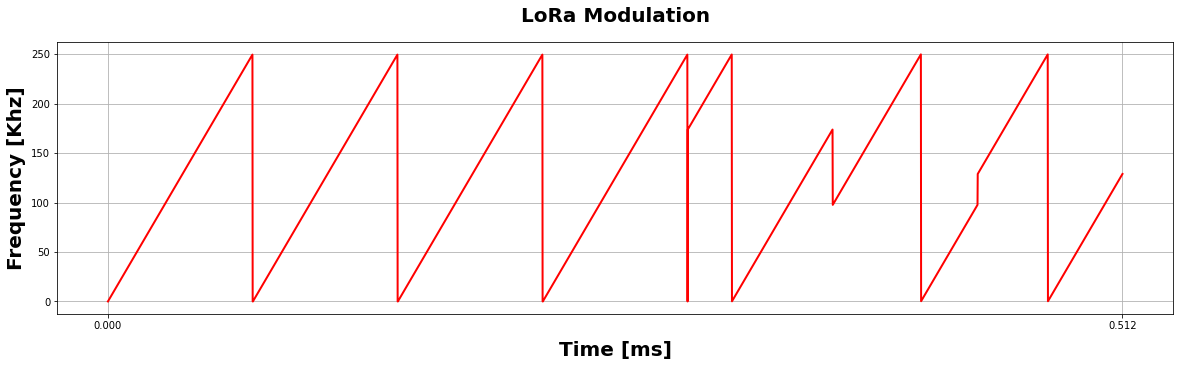

In [42]:
#----------------------------CONFIGURACION DE LA SEÑAL A TRANSMITIR-------------------------------------------#

sf = 7                     # Spreading factor. varia entre [7-12]
Bw = 250                   # Khz. Ancho de banda definido para la transmision. varia entre 125 o 250 o 500 [Khz]
Ts = 2**sf/Bw              # Tiempo de simbolo. Es el tiempo que tarda en enviarse un simbolo
n_data = 3                 # Cantidad de datos a transmitir por trama
delta = 0.20               # Paso
sps = int(2**sf * 1/delta) # Samples per symbol 
len_preamble = 4           # largo del preambulo en cantidad de simbolos

#---------------------------------------------------------------------------------------------------#

Symbs = [] # vector de simbolos a transmitir

if n_data > 1:
    symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, sps) # symbs son los datos generados aleatoriamente, data_tx son los chirp en frecuencia
    Symbs = symbs
    print("Simbolos transmitidos:", symbs)
elif n_data == 1:
    simbolo = 50 # Simbolo a transmitir
    Symbs.append(simbolo) 
    t_c = np.linspace(0, Ts, sps)
    data_tx_f = generate_chirp(Symbs[0], sf, Bw, t_c, sps) #chirp en frecuencia
    print("Simbolo transmitido:", Symbs[0])

# Grafico Frecuencia vs tiempo
fig1, ax1 = plt.subplots(1, figsize = (20, 5))    
fig1.patch.set_facecolor('white')

preambulo = generate_preamble(len_preamble, Bw, sf, sps)

t = np.linspace(0, Ts, sps*(n_data+len_preamble)) #Vector de tiempo

plot_waveform(ax1, t, np.append(preambulo,data_tx_f), "Time [ms]", "Frequency [Khz]", "LoRa Modulation", Ts, sps)

Tamaño de waveform_chirp_time: 4480
Simbolos transmitidos: [89 50 66]


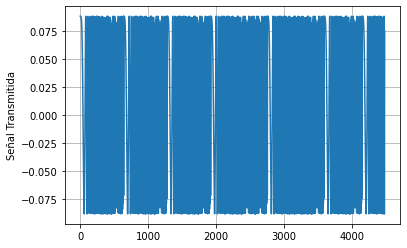

In [43]:
#--------------------------------------------- MODULACION LORA ----------------------------------------------------#
tx_signal = pream_sync(len_preamble, Symbs, Bw, sf, sps, delta)
size = len(tx_signal)

print("Tamaño de waveform_chirp_time:",size) #Tamaño de la señal completa con preambulo
print("Simbolos transmitidos:",Symbs)

# GRAFICOS DE SEÑAL TRANSMITIDA:
plt.figure()
plt.plot(np.real(tx_signal))
plt.ylabel("Señal Transmitida")
plt.grid()


Se construye una señal con una parte de sincronizacion que permite reconstruir posteriormente la señal en el receptor.

### Configuracion SDR

In [44]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.35" # RELLENAR CON LA IP DEL SDR ASIGNADO 
SamplingRate     = 2e6               # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1                 # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 926e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -20           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB] (-80 ya hay errores de deteccion)
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]. ancho de banda con el que esperamos configurar el transmisor

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "fast_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 3*len(tx_signal)  # Tamaño de buffer del receptor -> debe poder capturar varias tramas

In [45]:
#------------------------------- SDR Setup TRANSMISOR ------------------------------- 
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten  # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True     # enviar la señal muchas veces
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes  # Receive path AGC Options: slow_attack, fast_attack, manual
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize


In [46]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(tx_signal*2**14)


## Receptor

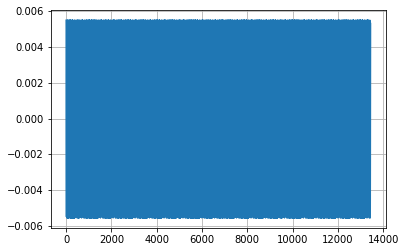

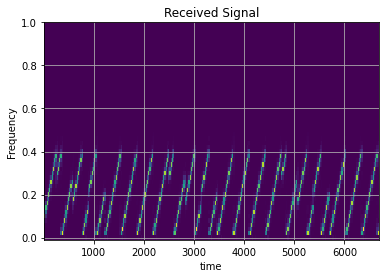

In [47]:
#------------------------------- Receiver -------------------------------

rxSignal = sdr.rx()/2**14

plt.figure()
plt.plot(np.real(rxSignal))
plt.grid()

plot_spectrogram("Received Signal", np.real(rxSignal), samples=2)

### Funciones de Recepcion

In [48]:
def isValidPreamble(preamble,len_preamb_sync):
    """
    isValidPreamble, verifica que el preambulo sea valido
    Arguments:
        - preamble          : preambulo a verificar
        - len_preamb_sync   : largo del preambulo
    Returns:
        - boolean, True si es valido, False caso contrario
    """
    for sim in preamble:
        if sim != 0:
            return False        
    return True

def find_preamble(rx_signal, sf, sps, len_preamb_sync, downchirp):
    """
    find_preamble, encuentra el preambulo en la señal
    Arguments:
        - rx_signal: señal recibida
        - sf: spreading factor
        - sps: samples per symbol
        - len_preamb_sync: largo del preambulo
        - downchirp: para demodular el preambulo
    Returns:
        - index: donde arranca el preambulo
    """
    valid = False
    index = 0
    while (not valid):
        # se busca el preambulo
        lora_mod_symbols = rx_signal[index::] # voy avanzando en la señal recibida hasta poder detectar el preambulo
        
        preamble = []
        
        for i in range(len_preamb_sync):
            
            if (i+1)*sps > len(lora_mod_symbols):
                break

            dechirped_symbol = lora_mod_symbols[i*sps:(i+1)*sps] * downchirp  # dechirped symbol
            corr = abs(np.fft.fft(dechirped_symbol))  # correlacion usando la fft

            symbol = np.argmax(corr) % 2**sf  # estimacion del simbolo
            
            preamble.append(symbol)  
            
            if symbol != 0:
                break
              
            

        if len(preamble) == len_preamb_sync :
            if isValidPreamble(preamble,len_preamb_sync):
                valid = True
                break
        
        index += 1
        if (index > len(rx_signal)-len_preamb_sync*sps):
            print("No se encontro el preambulo")
            break

    if not valid:
        print(index)
        raise Exception("No se encontro el preambulo")
    
    return index

def base_down_chirp(sf, Bw, delta):
    """
    base_down_chirp: genera el downchirp para la demodulacion LoRa
      Arguments:
          sf: spreading factor
          Bw: ancho de banda
          delta: espaciado entre frecuencias
      Returns:
          downchirp_t: downchirp en tiempo
          downchirp_f: frecuencia del downchirp
    """

    k = np.arange(2**sf, 0, -delta)
    f = k * Bw / (2**sf)                # frecuencias del downchirp
    t = k * 1 / Bw                      # tiempo del downchirp

    downchirp = (1 / (np.sqrt(2**sf))) * np.exp(-1j * 2 * np.pi * f * t * 1 / 2)

    return downchirp, f


def sincronizar(rx_signal, sf, Bw, delta, sps, len_preamble, Nsymbols):
    """
    sincronizar, reacomoda la señal recibida buscando el preambulo
    Arguments:
        - rxSignal              : señal recibida
        - cantidad_zeros        : cantidad de ceros de sincronizacion
        - valor_tolerancia      : valor maximo al cual considerar la muestra como 0

    Returns:
        - data_signal           : señal sincronizada con informacion
    """
    downchirp, _   = base_down_chirp(sf, Bw, delta)

    preamble_start = find_preamble(rx_signal, sf, sps, len_preamble, downchirp)
    
    start       = preamble_start + len_preamble*sps #Inicio de la señal y final del preambulo
    end         = start + Nsymbols*sps
    
    data_signal = rx_signal[start:end] # señal de datos
    
    return data_signal



### Sincronizacion

1920


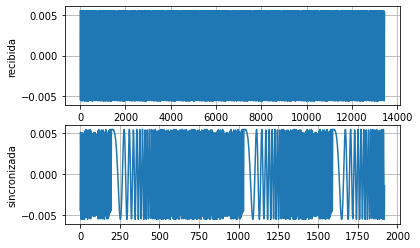

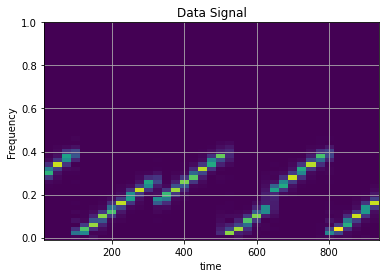

In [49]:

rx_sync = sincronizar(rxSignal, sf, Bw, delta, sps, len_preamble, n_data)

# Grafico señal reconstruida y original recibida

plt.figure()
plt.subplot(2,1,1)
plt.plot(np.real(rxSignal))
plt.ylabel("recibida")
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.real(rx_sync))
plt.ylabel("sincronizada")
plt.grid()

print(len(rx_sync)) # Tamaño de señal reconstruida

plot_spectrogram("Data Signal", np.real(rx_sync), samples=2)

### Demodulacion

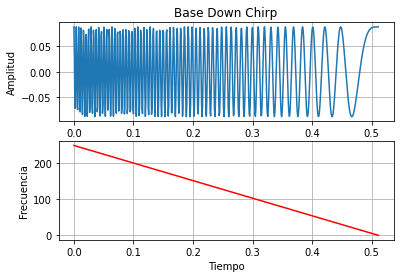

In [50]:
#Inicialización del down Chirp

base_down_chirp_t, base_down_chirp_f = base_down_chirp(sf, Bw, delta)
num_muestras = int(2**sf*1/delta)

#Grafico de las componentes del down chirp
t=np.arange(0, num_muestras*delta/Bw, delta/Bw)

plt.figure()
plt.subplot(2,1,1)
plt.title("Base Down Chirp")
plt.plot(t,np.real(base_down_chirp_t))
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t,base_down_chirp_f, color = "red")
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.grid()


Simbolos transmitidos :  [89 50 66]
Simbolos estimados:  [89, 50, 66]


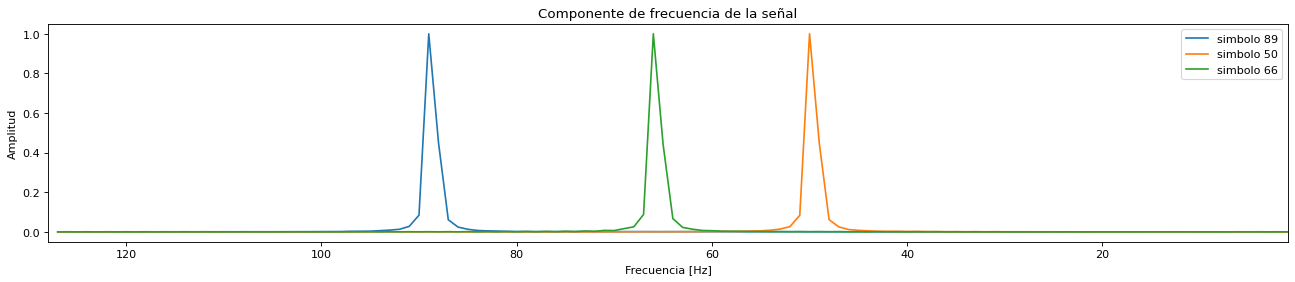

In [52]:
#--------------------------------Estimador de simbolo----------------------------------------------------#
lora_symbols_n    = rx_sync[0::int(1/delta)]
base_down_chirp_n = base_down_chirp_t[0::int(1/delta)]    

corrs = [] #Matriz
simbolos_estimados = []


for i in range(n_data):
    
    lora_symbols_n_aux = lora_symbols_n[i*2**sf:(i+1)*2**sf]

    # paso 1 - multiplicar por downchirp
    dechirped = lora_symbols_n_aux * base_down_chirp_n
    
    # paso 2 - fft
    corr = abs(np.fft.fft(dechirped))**2 # correlacion del wf recibido con la base
    
    # paso 3 - estimacion del simbolo
    simbolo_estimado = np.argmax(corr) # se toma el indice de mayor correlacion como el simbolo transmitido
    
    corrs.append(corr)
    simbolos_estimados.append(simbolo_estimado) 
    

print("Simbolos transmitidos : ",Symbs)
print("Simbolos estimados: ",simbolos_estimados)

graficar_correlaciones(corrs,simbolos_estimados,sf)

In [53]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
TxAtten  = -70
RxLOFreq = 2400e6
sdr.tx(np.zeros(1024))


In [54]:
# Destroy radio object
del(sdr)